In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from preprocessing_mne import get_raw_subject_data

In [2]:
# def reshape_epochs(epochs, n_epochs_to_include):
#     """
#     Truncate the Epochs to a defined number and merge their time samples.
    
#     Parameters:
#         epochs (MNE Epochs): The epochs object containing the data.
#         n_epochs_to_include (int): The maximum number of epochs to consider.
        
#     Returns:
#         ndarray: A 2D array where each row represents a time point (merged from epochs)
#                  and each column corresponds to a channel.
#     """
#     # Retrieve and limit the epoch data
    
#     """Limit epochs to min bound, reshape data to channels x merged_epochs"""
#     epoch_data = epochs.get_data()[:n_epochs_to_include, :, :]
#     # epoch_data = epoch.get_data()
#     n_epoch, n_channels, n_epoch_size = epoch_data.shape
#     epoch_data_reshaped = epoch_data.reshape(n_channels, n_epoch * n_epoch_size)
#     return epoch_data_reshaped.T

In [3]:
def reshape_epochs_with_indices(epochs, n_epochs_to_include):
    """
    Truncate the epochs to a given number, reshape their time samples,
    and also return an index array that labels each time sample with the
    original epoch index.
    """
    # Get epoch data: shape (n_epochs, n_channels, n_epoch_size)
    epoch_data = epochs.get_data()[:n_epochs_to_include, :, :]
    n_epoch, n_channels, n_epoch_size = epoch_data.shape
    # Reshape to (n_epochs*n_epoch_size, n_channels)
    epoch_data_reshaped = epoch_data.reshape(n_channels, n_epoch * n_epoch_size).T
    # Create an index array indicating the original epoch number for each sample
    orig_indices = np.repeat(epochs.selection[:n_epochs_to_include], n_epoch_size)
    return epoch_data_reshaped, orig_indices

In [4]:
# epochs = get_raw_subject_data(subject=3)

# # Divide each activity and find the minimum number of samples
# control = epochs['Control']
# left = epochs['Tapping_Left']
# right = epochs['Tapping_Right']
# min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

# # Reshape all activities
# control_reshaped = reshape_epochs(control, min_bound)
# left_reshaped = reshape_epochs(left, min_bound)
# right_reshaped = reshape_epochs(right, min_bound)
# X = np.concatenate([control_reshaped, left_reshaped, right_reshaped], axis=0)

# l = control_reshaped.shape[0]
# y = np.concatenate([np.full(l, 1), np.full(l, 2), np.full(l, 3)])

# # Standardize data (should not be necessary for ICA, but good practice)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
# X_ica = ica.fit_transform(X_scaled)

# # # Plot the raw epochs time series with epoch boundaries
# # plt.figure(figsize=(12, 6))
# # plt.plot(X, color='gray')
# # plt.axvline(x=l, color='black', linestyle='--', label='Control → Tapping Left')
# # plt.axvline(x=2*l, color='black', linestyle='--', label='Tapping Left → Tapping Right')
# # plt.xlabel('Time (samples)')
# # plt.ylabel('Amplitude')
# # plt.title('Time Series of Concatenated Epochs')
# # plt.legend()
# # plt.tight_layout()
# # plt.show()

In [5]:
# epochs = get_raw_subject_data(subject=3)

# # Di# Divide each activity and find the minimum number of epochs available
# control = epochs['Control']
# left = epochs['Tapping_Left']
# right = epochs['Tapping_Right']
# min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

# # Reshape all activities and get original epoch indices per sample
# control_data, ctrl_idx = reshape_epochs_with_indices(control, min_bound)
# left_data, left_idx = reshape_epochs_with_indices(left, min_bound)
# right_data, right_idx = reshape_epochs_with_indices(right, min_bound)

# # Concatenate data and corresponding indices/lables
# X = np.concatenate([control_data, left_data, right_data], axis=0)
# orig_indices = np.concatenate([ctrl_idx, left_idx, right_idx])
# print(left_idx)
# print(right_idx)
# print(ctrl_idx)
# print(orig_indices)
# y = np.concatenate([np.full(control_data.shape[0], 1),
#                     np.full(left_data.shape[0], 2),
#                     np.full(right_data.shape[0], 3)])

# # Standardize and run ICA as before
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
# X_ica = ica.fit_transform(X_scaled)

# # Reconstruct the original order by sorting on orig_indices
# perm = np.argsort(orig_indices)
# X_ica_ordered = X_ica[perm, :]
# y_ordered = y[perm]

Reading 0 ... 23120  =      0.000 ...  2959.360 secs...
Boundaries: [0, 4082, 8164, 12246]


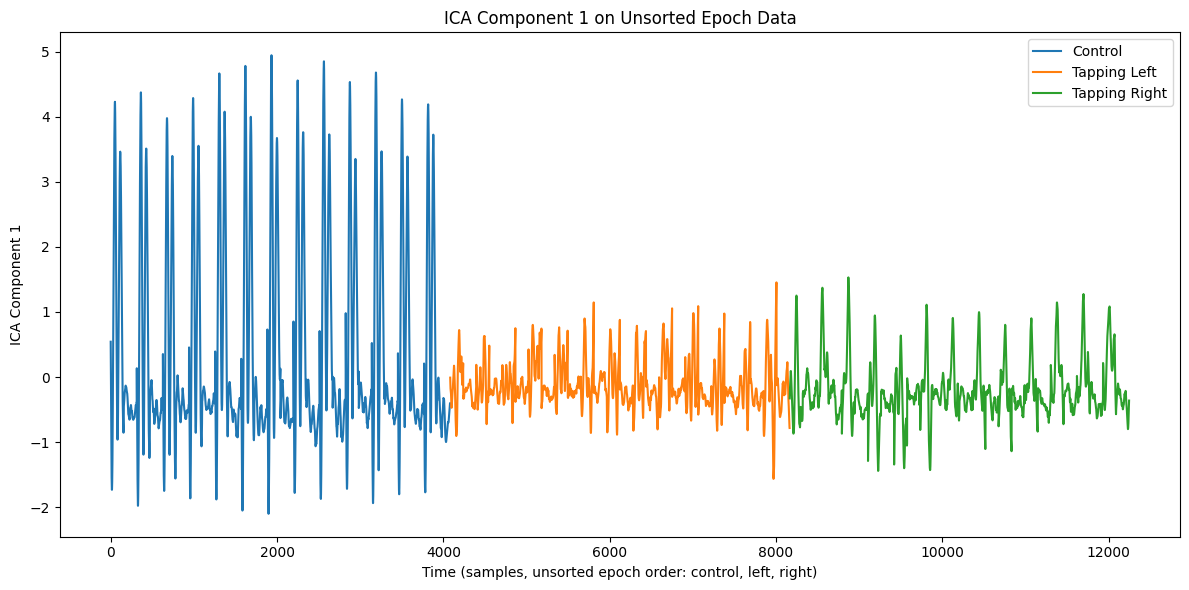

In [6]:
# --- Get raw epochs and reshape them with indices (as before)
epochs = get_raw_subject_data(subject=3)

control = epochs['Control']
left = epochs['Tapping_Left']
right = epochs['Tapping_Right']
min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

control_data, ctrl_idx = reshape_epochs_with_indices(control, min_bound)
left_data, left_idx = reshape_epochs_with_indices(left, min_bound)
right_data, right_idx = reshape_epochs_with_indices(right, min_bound)

# Concatenate in the original order: control, tapping left, tapping right
X = np.concatenate([control_data, left_data, right_data], axis=0)
# Here the class labels come in order naturally:
y = np.concatenate([np.full(control_data.shape[0], 1),
                    np.full(left_data.shape[0], 2),
                    np.full(right_data.shape[0], 3)])

# --- Pass the data into ICA WITHOUT any reordering --------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
X_ica_unsorted = ica.fit_transform(X_scaled)
y_unsorted = y  # the order is as originally concatenated

# --- Now define the boundaries corresponding to each condition ----------
n_control = control_data.shape[0]
n_left = left_data.shape[0]
n_right = right_data.shape[0]
# Boundaries along the time axis (each epoch chunk is contiguous)
boundaries = [0, n_control, n_control + n_left, n_control + n_left + n_right]
print("Boundaries:", boundaries)

# --- Plot the ICA time series for Component 1 using the unsorted data ---
plt.figure(figsize=(12, 6))
colors = {1: "C0", 2: "C1", 3: "C2"}

# Plot control block
plt.plot(np.arange(boundaries[0], boundaries[1]),
         X_ica_unsorted[boundaries[0]:boundaries[1], 0],
         color=colors[1], label="Control")

# Plot tapping left block
plt.plot(np.arange(boundaries[1], boundaries[2]),
         X_ica_unsorted[boundaries[1]:boundaries[2], 0],
         color=colors[2], label="Tapping Left")

# Plot tapping right block
plt.plot(np.arange(boundaries[2], boundaries[3]),
         X_ica_unsorted[boundaries[2]:boundaries[3], 0],
         color=colors[3], label="Tapping Right")

plt.xlabel("Time (samples, unsorted epoch order: control, left, right)")
plt.ylabel("ICA Component 1")
plt.title("ICA Component 1 on Unsorted Epoch Data")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import FastICA
# from sklearn.preprocessing import StandardScaler
# from preprocessing_mne import get_raw_subject_data

# # --- Get epochs and reshape them (as before) ---
# epochs = get_raw_subject_data(subject=3)
# control = epochs['Control']
# left = epochs['Tapping_Left']
# right = epochs['Tapping_Right']
# min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

# control_data, ctrl_idx = reshape_epochs_with_indices(control, min_bound)
# left_data, left_idx = reshape_epochs_with_indices(left, min_bound)
# right_data, right_idx = reshape_epochs_with_indices(right, min_bound)

# # Create class labels for each block
# y_control = np.full(control_data.shape[0], 1)
# y_left    = np.full(left_data.shape[0], 2)
# y_right   = np.full(right_data.shape[0], 3)

# # Concatenate all data and labels in the original order
# X = np.concatenate([control_data, left_data, right_data], axis=0)
# y = np.concatenate([y_control, y_left, y_right])

# # --- Randomize the order of the concatenated data ---
# perm = np.random.permutation(X.shape[0])
# X_random = X[perm, :]
# y_random = y[perm]

# # --- Standardize and run ICA ---
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_random)
# ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
# X_ica_random = ica.fit_transform(X_scaled)

# # --- Plotting ICA Component 1 with samples color-coded by class ---
# plt.figure(figsize=(12, 6))
# colors = {1: "C0", 2: "C1", 3: "C2"}

# for lab in np.unique(y_random):
#     mask = y_random == lab
#     plt.plot(np.where(mask)[0], X_ica_random[mask, 0], color=colors[lab], label=f"Class {lab}")

# plt.xlabel("Samples (randomized order)")
# plt.ylabel("ICA Component 1")
# plt.title("ICA Component 1 on Randomized Epoch Data")
# plt.legend()
# plt.tight_layout()
# plt.show()

Reading 0 ... 23120  =      0.000 ...  2959.360 secs...


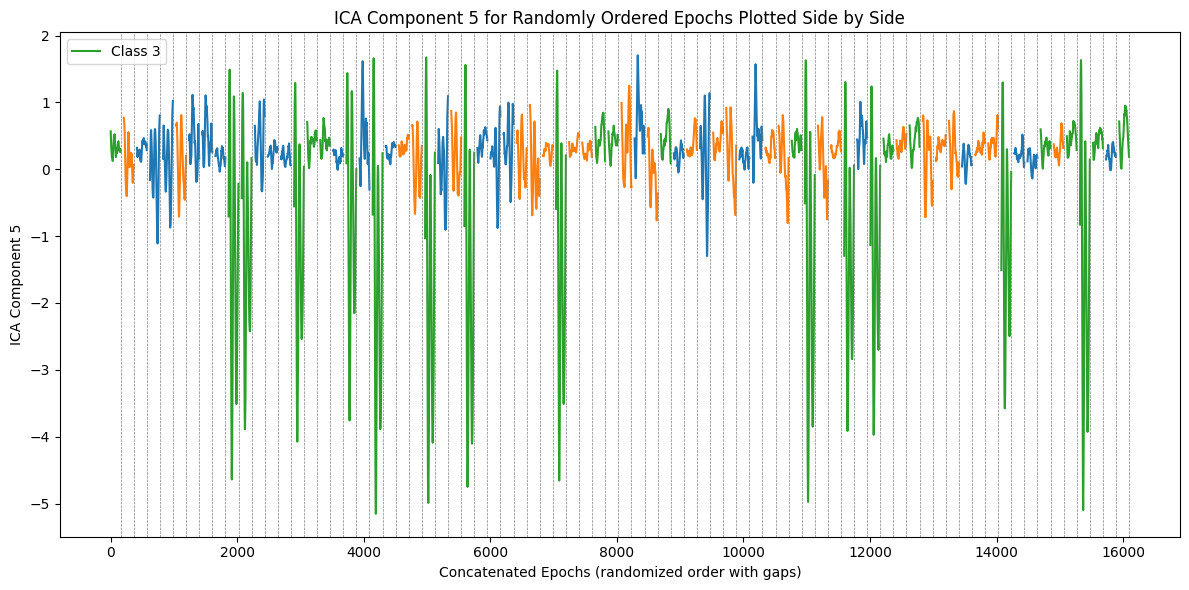

In [8]:
# New cell in ICA_stacked_epochs.ipynb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from preprocessing_mne import get_raw_subject_data

# --- Get epochs and reshape them (as before) ---
epochs = get_raw_subject_data(subject=3)
control = epochs['Control']
left = epochs['Tapping_Left']
right = epochs['Tapping_Right']
min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

control_data, ctrl_idx = reshape_epochs_with_indices(control, min_bound)
left_data, left_idx = reshape_epochs_with_indices(left, min_bound)
right_data, right_idx = reshape_epochs_with_indices(right, min_bound)

# Concatenate data, epoch indices, and labels
X = np.concatenate([control_data, left_data, right_data], axis=0)
orig_indices = np.concatenate([ctrl_idx, left_idx, right_idx])
y = np.concatenate([np.full(control_data.shape[0], 1),
                    np.full(left_data.shape[0], 2),
                    np.full(right_data.shape[0], 3)])

# --- Standardize and run ICA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
X_ica = ica.fit_transform(X_scaled)

# --- Reorder epochs randomly and plot them side by side ---
# Each unique value in orig_indices corresponds to one epoch
unique_epochs = np.unique(orig_indices)
# Randomize the order of these epochs
rand_epochs = np.random.permutation(unique_epochs)

gap = 50      # gap (in samples) between each epoch's plot
x_offset = 0  # current horizontal offset
plt.figure(figsize=(12, 6))
colors = {1: "C0", 2: "C1", 3: "C2"}

for epoch_id in rand_epochs:
    # Select all samples belonging to the current epoch
    ep_mask = orig_indices == epoch_id
    # Extract ICA Component 1 for this epoch
    ep_data = X_ica[ep_mask, 4]
    # All samples in the same epoch have the same class label
    label = y[ep_mask][0]
    # Create an x-axis for this epoch (shifted by current offset)
    x_range = np.arange(len(ep_data)) + x_offset
    plt.plot(x_range, ep_data, color=colors[label],
             label=f"Class {label}" if x_offset == 0 else "")
    # Draw a separator line at the end of the epoch segment
    plt.axvline(x=x_offset + len(ep_data), color='gray', linestyle='--', linewidth=0.5)
    # Update offset: current epoch length plus a fixed gap
    x_offset += len(ep_data) + gap

plt.xlabel("Concatenated Epochs (randomized order with gaps)")
plt.ylabel("ICA Component 5")
plt.title("ICA Component 5 for Randomly Ordered Epochs Plotted Side by Side")
plt.legend()
plt.tight_layout()
plt.show()

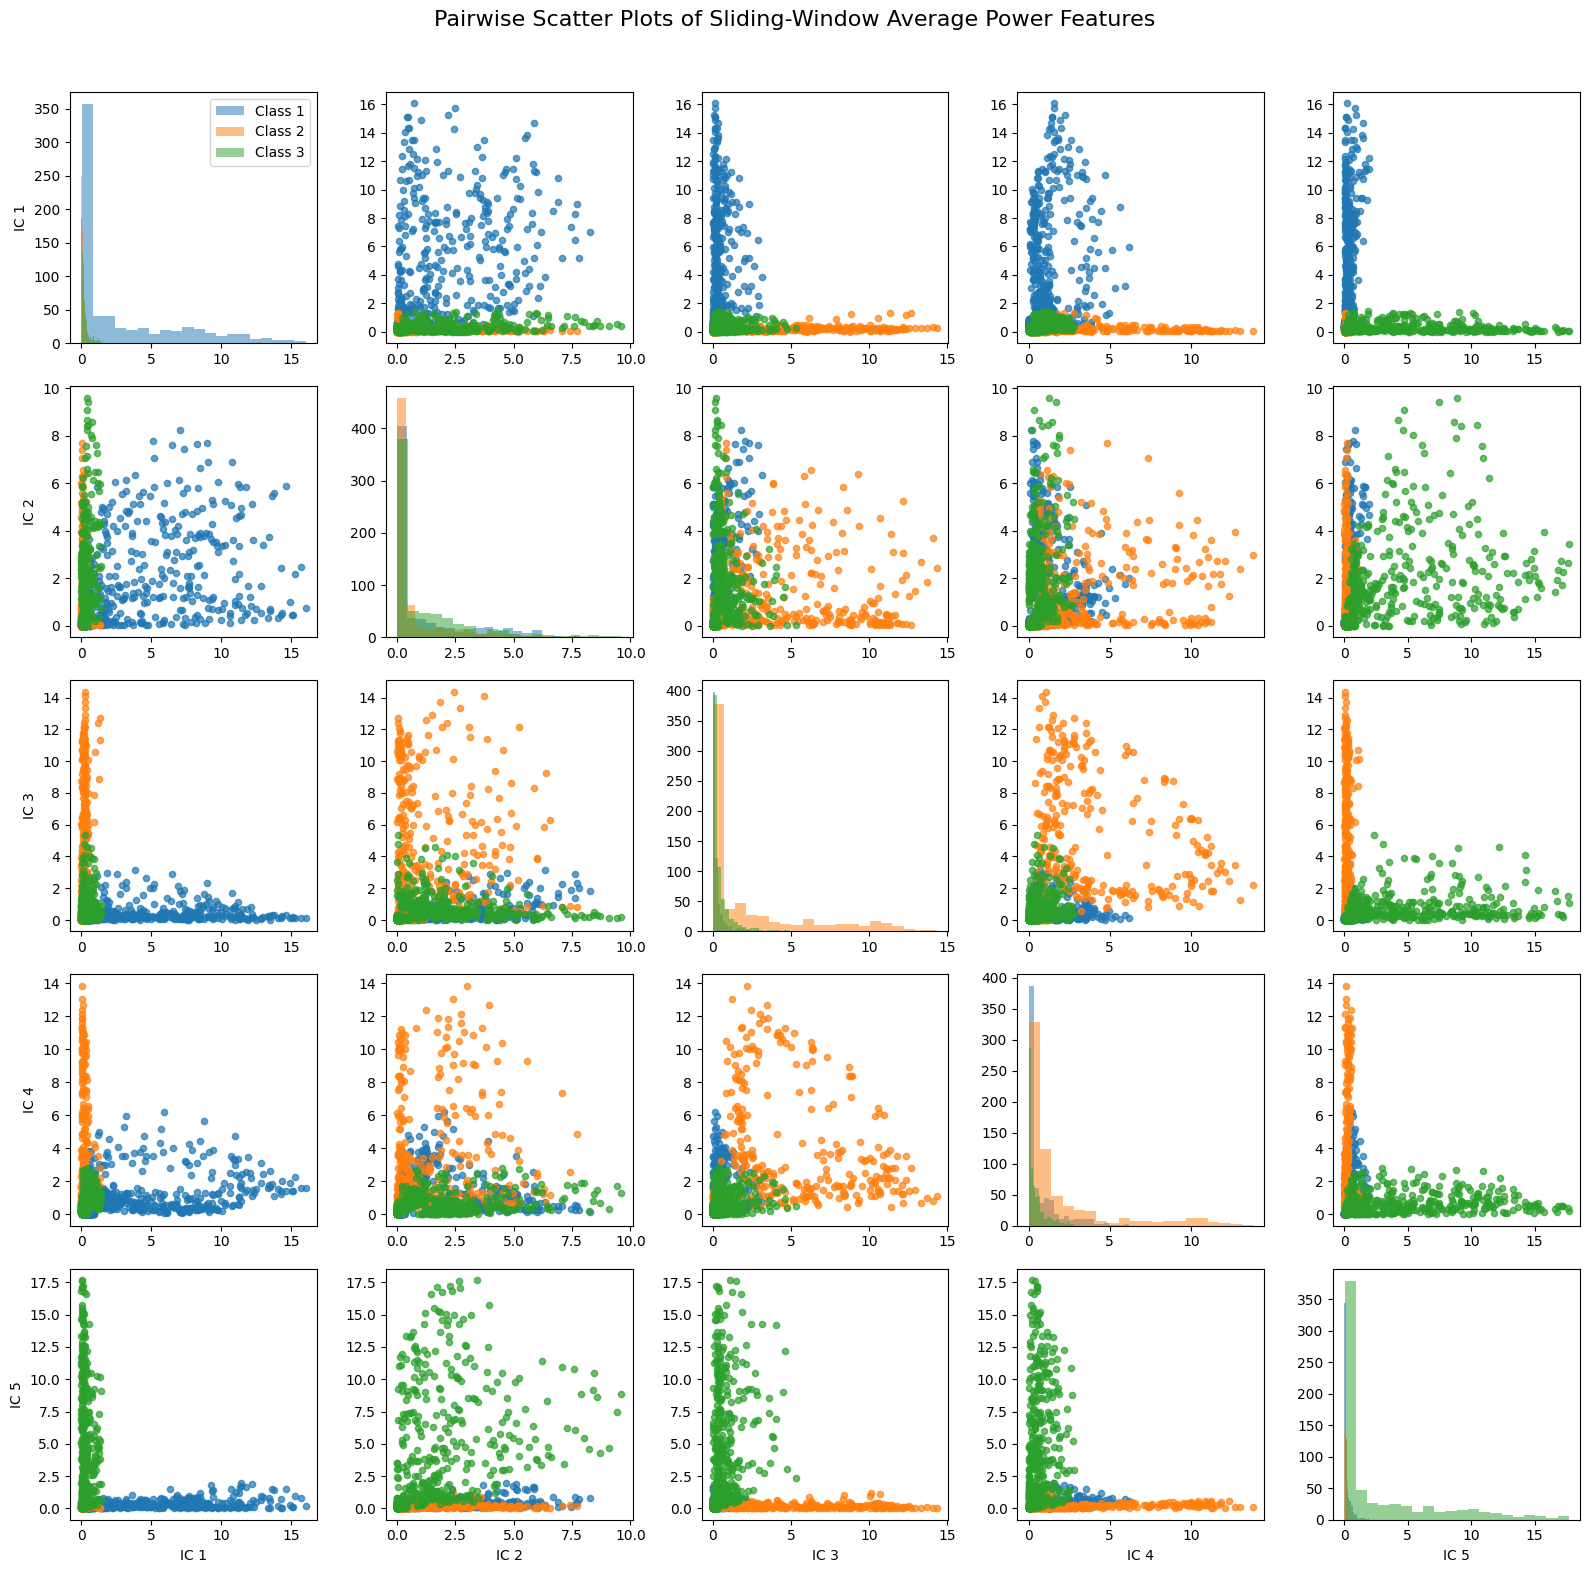

In [9]:
# New cell in ICA_stacked_epochs.ipynb
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters for sliding window ---
window_size = 30  # window length in samples
step_size = 5     # step size

# Lists to store feature vectors and corresponding labels
features_list = []
labels_list = []

# Iterate over each epoch using orig_indices
unique_epochs = np.unique(orig_indices)
for epoch_id in unique_epochs:
    # Get all samples for this epoch
    epoch_mask = orig_indices == epoch_id
    epoch_data = X_ica[epoch_mask, :]  # shape: (n_epoch_samples, 5)
    # All samples in an epoch share the same class label
    epoch_label = y[epoch_mask][0]
    n_samples_epoch = epoch_data.shape[0]
    
    # Slide a window over this epoch without crossing its boundary
    for start in range(0, n_samples_epoch - window_size + 1, step_size):
        end = start + window_size
        window = epoch_data[start:end, :]
        # Compute average power (mean square) for each component
        avg_power = np.mean(window**2, axis=0)  # (5,)
        features_list.append(avg_power)
        labels_list.append(epoch_label)

# Final features: each row is a 5-D feature vector for one window
features = np.array(features_list)   # shape: (n_windows_total, 5)
labels = np.array(labels_list)

# --- Plot pairwise scatter plots of the 5-D power feature vectors ---
n_components = features.shape[1]
colors = {1: "C0", 2: "C1", 3: "C2"}

fig, axes = plt.subplots(n_components, n_components, figsize=(16, 16))
fig.suptitle("Pairwise Scatter Plots of Sliding-Window Average Power Features", fontsize=16)

for i in range(n_components):
    for j in range(n_components):
        ax = axes[i, j]
        if i == j:
            # Plot a histogram on the diagonal
            for cl in sorted(np.unique(labels)):
                cl_mask = labels == cl
                ax.hist(features[cl_mask, i], bins=20, alpha=0.5, color=colors[cl],
                        label=f"Class {cl}")
            if i == 0:
                ax.legend()
        else:
            # Scatter plot: x-axis: component j, y-axis: component i
            for cl in sorted(np.unique(labels)):
                cl_mask = labels == cl
                ax.scatter(features[cl_mask, j], features[cl_mask, i],
                           color=colors[cl], alpha=0.7, s=20, label=f"Class {cl}" if (i==0 and j==n_components-1) else "")
        if i == n_components - 1:
            ax.set_xlabel(f"IC {j+1}")
        if j == 0:
            ax.set_ylabel(f"IC {i+1}")

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

Number of windows: 2028
Clusters: 2, Silhouette Score: 0.5373
Clusters: 3, Silhouette Score: 0.5994


c:\Users\oscar\anaconda3\envs\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\oscar\anaconda3\envs\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\oscar\anaconda3\envs\venv\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oscar\anaconda3\envs\venv\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\oscar\anaconda3\envs\venv\Lib\subprocess.py", line 1538, in _exec

Clusters: 4, Silhouette Score: 0.6526
Clusters: 5, Silhouette Score: 0.6724
Clusters: 6, Silhouette Score: 0.6049
Clusters: 7, Silhouette Score: 0.5946
Clusters: 8, Silhouette Score: 0.5874
Clusters: 9, Silhouette Score: 0.5709
Clusters: 10, Silhouette Score: 0.5947


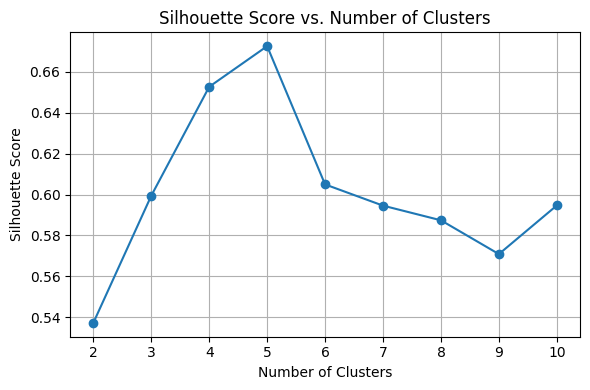

Optimal number of clusters based on silhouette score: 5


In [10]:
# New cell in ICA_stacked_epochs.ipynb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test a range of cluster counts (e.g., from 2 to 10)
cluster_range = range(2, 11)
sil_scores = []

print(f'Number of windows: {features.shape[0]}')

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    score = silhouette_score(features, cluster_labels)
    sil_scores.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(list(cluster_range), sil_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(list(cluster_range))
plt.grid(True)
plt.tight_layout()
plt.show()

best_k = cluster_range[np.argmax(sil_scores)]
print(f"Optimal number of clusters based on silhouette score: {best_k}")

Number of control windows: 676
Clusters: 2, Silhouette Score: 0.6624
Clusters: 3, Silhouette Score: 0.5924
Clusters: 4, Silhouette Score: 0.5748
Clusters: 5, Silhouette Score: 0.5851
Clusters: 6, Silhouette Score: 0.5925
Clusters: 7, Silhouette Score: 0.5847
Clusters: 8, Silhouette Score: 0.5834
Clusters: 9, Silhouette Score: 0.5793
Clusters: 10, Silhouette Score: 0.5929


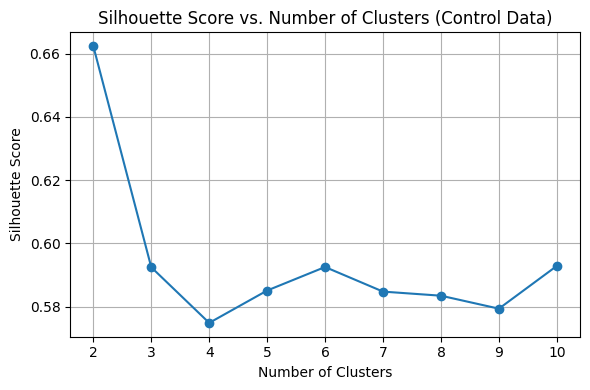

Optimal number of clusters for control data: 2


In [11]:
# New cell in ICA_stacked_epochs.ipynb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Using the previously computed sliding-window features (power_features)
# and the corresponding window_labels (where class 1 = Control):
control_mask = (labels == 1)
control_power_features = features[control_mask]

print("Number of control windows:", control_power_features.shape[0])

# Test a range of cluster counts (e.g., from 2 to 10) on control data
cluster_range = range(2, 11)
sil_scores_control = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels_control = kmeans.fit_predict(control_power_features)
    score = silhouette_score(control_power_features, cluster_labels_control)
    sil_scores_control.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(list(cluster_range), sil_scores_control, marker='o')
plt.title("Silhouette Score vs. Number of Clusters (Control Data)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(list(cluster_range))
plt.grid(True)
plt.tight_layout()
plt.show()

best_k_control = cluster_range[np.argmax(sil_scores_control)]
print(f"Optimal number of clusters for control data: {best_k_control}")

## Getting more clusters when including tapping data

We define a control preiod before the tapping command is given. Then define a tapping period after. Pass this data into the ICA, run a sliding window average power computation (skipping the overlap between different epochs) and checking for clusters.

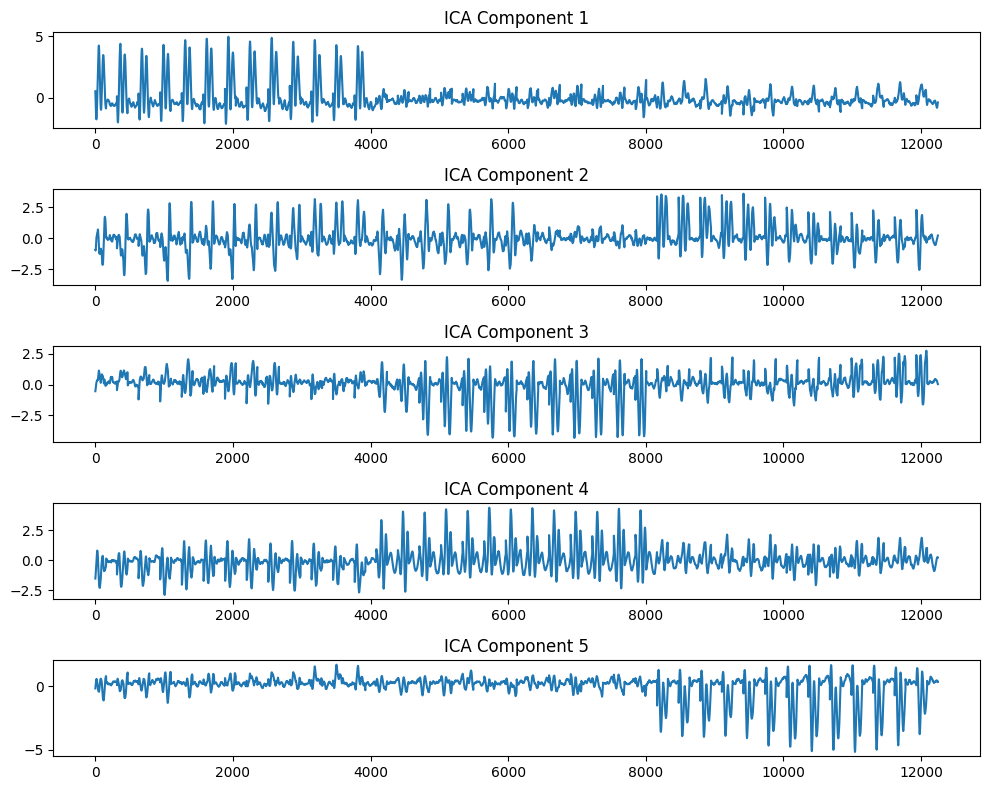

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(X_ica.shape[1]):
    plt.subplot(X_ica.shape[1], 1, i + 1)
    plt.plot(X_ica[:, i])
    plt.title(f'ICA Component {i + 1}')
plt.tight_layout()
plt.show()

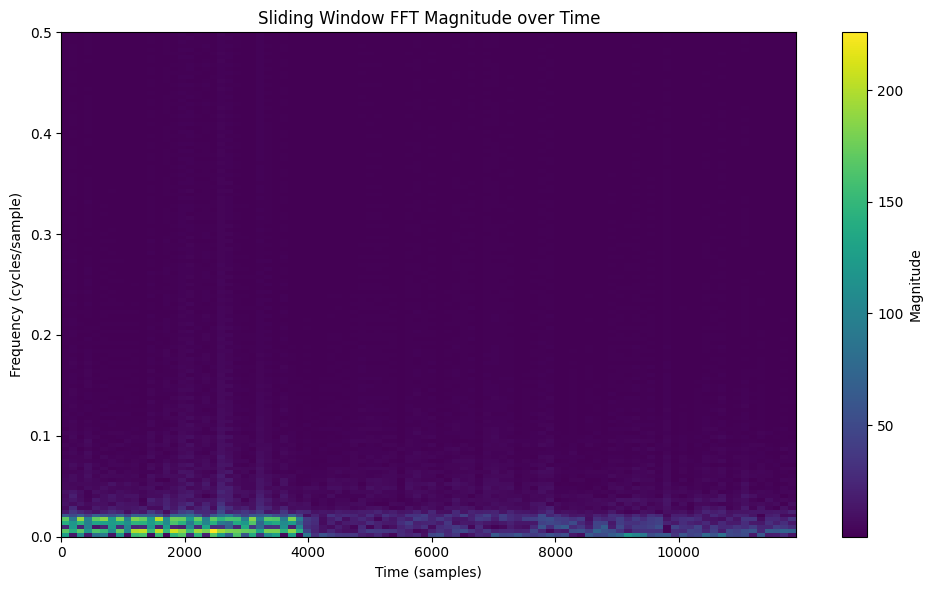

In [13]:
# Select the first channel from X as the signal for FFT analysis
signal = X_ica[:, 0]

# Define window and step sizes
win_size = 256      # window length (number of samples)
step_size = 128     # sliding step

# Calculate the number of windows
num_windows = (len(signal) - win_size) // step_size + 1

# Pre-allocate the spectrogram array (only non-negative frequencies are returned)
spectrogram = np.zeros((num_windows, win_size // 2 + 1))

# Compute FFT for each window and store the magnitude spectrum
for i in range(num_windows):
    start = i * step_size
    window_data = signal[start:start + win_size]
    fft_result = np.fft.rfft(window_data)
    spectrogram[i, :] = np.abs(fft_result)

# Frequency axis for FFT (in cycles per sample)
freqs = np.fft.rfftfreq(win_size, d=1)

# Time axis: here we use the starting index of each window as the time marker
times = np.arange(num_windows) * step_size

# Plot the spectrogram as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=(times[0], times[-1], freqs[0], freqs[-1]))
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (cycles/sample)')
plt.title('Sliding Window FFT Magnitude over Time')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()